# Decision Trees

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Why are we learning about decision trees?

- Can be applied to both regression and classification problems
- Many useful properties
- Very popular
- Basis for more sophisticated models
- Have a different way of "thinking" than the other models we have studied

## Lesson objectives

Students will be able to:

- Explain how a decision tree is created
- Build a decision tree model in scikit-learn
- Tune a decision tree model and explain how tuning impacts the model
- Interpret a tree diagram
- Describe the key differences between regression and classification trees
- Decide whether a decision tree is an appropriate model for a given problem

# Part 1: Regression trees

Major League Baseball player data from 1986-87:

- **Years** (x-axis): number of years playing in the major leagues
- **Hits** (y-axis): number of hits in the previous year
- **Salary** (color): low salary is blue/green, high salary is red/yellow

![Salary data](images/salary_color.png)

Group exercise:

- The data above is our **training data**.
- We want to build a model that predicts the Salary of **future players** based on Years and Hits.
- We are going to "segment" the feature space into regions, and then use the **mean Salary in each region** as the predicted Salary for future players.
- Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

Rules for segmenting:

- You can only use **straight lines**, drawn one at a time.
- Your line must either be **vertical or horizontal**.
- Your line **stops** when it hits an existing line.

![Salary regions](images/salary_regions.png)

Above are the regions created by a computer:

- $R_1$: players with **less than 5 years** of experience, mean Salary of **\$166,000 **
- $R_2$: players with **5 or more years** of experience and **less than 118 hits**, mean Salary of **\$403,000 **
- $R_3$: players with **5 or more years** of experience and **118 hits or more**, mean Salary of **\$846,000 **

**Note:** Years and Hits are both integers, but the convention is to use the **midpoint** between adjacent values to label a split.

These regions are used to make predictions on **out-of-sample data**. Thus, there are only three possible predictions! (Is this different from how **linear regression** makes predictions?)

Below is the equivalent regression tree:

![Salary tree](images/salary_tree.png)

The first split is **Years < 4.5**, thus that split goes at the top of the tree. When a splitting rule is **True**, you follow the left branch. When a splitting rule is **False**, you follow the right branch.

For players in the **left branch**, the mean Salary is \$166,000, thus you label it with that value. (Salary has been divided by 1000 and log-transformed to 5.11.)

For players in the **right branch**, there is a further split on **Hits < 117.5**, dividing players into two more Salary regions: \$403,000 (transformed to 6.00), and \$846,000 (transformed to 6.74).

![Salary tree annotated](images/salary_tree_annotated.png)

**What does this tree tell you about your data?**

- Years is the most important factor determining Salary, with a lower number of Years corresponding to a lower Salary.
- For a player with a lower number of Years, Hits is not an important factor determining Salary.
- For a player with a higher number of Years, Hits is an important factor determining Salary, with a greater number of Hits corresponding to a higher Salary.

**Question:** What do you like and dislike about decision trees so far?

## Building a regression tree by hand

Your **training data** is a tiny dataset of [used vehicle sale prices](https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv). Your goal is to **predict price** for testing data.

1. Read the data into a Pandas DataFrame.
2. Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
3. Decide which feature is the most important predictor, and use that to create your first splitting rule.
    - Only binary splits are allowed.
4. After making your first split, split your DataFrame into two parts, and then explore each part to figure out what other splits to make.
5. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting.
    - Your goal is to build a model that generalizes well.
    - You are allowed to split on the same variable multiple times!
6. Draw your tree, labeling the leaves with the mean price for the observations in that region.
    - Make sure nothing is backwards: You follow the **left branch** if the rule is true, and the **right branch** if the rule is false.

## How does a computer build a regression tree?

**Ideal approach:** Consider every possible partition of the feature space (computationally infeasible)

**"Good enough" approach:** recursive binary splitting

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating step 3 until a **stopping criterion** is met:
    - maximum tree depth (maximum number of splits required to arrive at a leaf)
    - minimum number of observations in a leaf

### Demo: Choosing the ideal cutpoint for a given feature

In [1]:
# vehicle data
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv'
train = pd.read_csv(url)

In [2]:
# before splitting anything, just predict the mean of the entire dataset
train['prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [3]:
# calculate RMSE for those predictions
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.9819859959835

In [20]:
# define a function that calculates the RMSE for a given split of miles
def mileage_split(miles, df):
    lower_mileage_price = df[df.miles < miles].price.mean()
    higher_mileage_price = df[df.miles >= miles].price.mean()
    df['prediction'] = np.where(df.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(df.price, df.prediction))


def year_split(year, df):
    lower_year_price = df[df.year < year].price.mean()
    higher_year_price = df[df.year >= year].price.mean()
    df['prediction'] = np.where(df.year < year, lower_year_price, higher_year_price)
    return np.sqrt(metrics.mean_squared_error(df.price, df.prediction))

In [16]:
# calculate RMSE for tree which splits on miles < 50000
print 'RMSE:', mileage_split(50000, train)
train

RMSE: 3984.09174254


,price,year,miles,doors,vtype,prediction,vtype_int
0,22000,2012,13000,2,car,15000.000000,0
1,14000,2010,30000,2,car,15000.000000,0
2,13000,2010,73500,4,car,4272.727273,0
3,9500,2009,78000,4,car,4272.727273,0
4,9000,2007,47000,4,car,15000.000000,0
5,4000,2006,124000,2,car,4272.727273,0
6,3000,2004,177000,4,car,4272.727273,0
7,2000,2004,209000,4,truck,4272.727273,1
8,3000,2003,138000,2,car,4272.727273,0
9,1900,2003,160000,4,car,4272.727273,0


In [17]:
# calculate RMSE for tree which splits on miles < 100000
print 'RMSE:', mileage_split(100000, train)
train

RMSE: 3530.14653008


,price,year,miles,doors,vtype,prediction,vtype_int
0,22000,2012,13000,2,car,12083.333333,0
1,14000,2010,30000,2,car,12083.333333,0
2,13000,2010,73500,4,car,12083.333333,0
3,9500,2009,78000,4,car,12083.333333,0
4,9000,2007,47000,4,car,12083.333333,0
5,4000,2006,124000,2,car,2437.500000,0
6,3000,2004,177000,4,car,2437.500000,0
7,2000,2004,209000,4,truck,2437.500000,1
8,3000,2003,138000,2,car,2437.500000,0
9,1900,2003,160000,4,car,2437.500000,0


In [29]:
# check all possible mileage splits
mileage_range = range(train.miles.min(), train.miles.max(), 1000)
RMSE = [mileage_split(miles, train) for miles in mileage_range]

train_1 = train[train.miles < 100000]
train_2 = train[train.miles >= 100000]
year_1_range = range(train_1.year.min(), train_1.year.max(), 1)
year_2_range = range(train_2.year.min(), train_2.year.max(), 1)

rmse_1 = [year_split(years, train_1) for years in year_1_range]
rmse_2 = [year_split(years, train_2) for years in year_2_range]

c:\Users\user\Anaconda\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
rmse_2

[810.76738340907627,
 687.38635424337599,
 687.38635424337599,
 628.32449153814355,
 628.32449153814355,
 628.32449153814355,
 628.32449153814355,
 683.73971655886714,
 555.49205986353081]

In [22]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

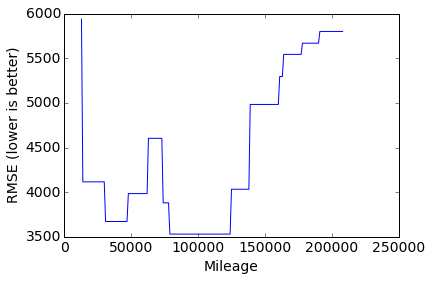

In [30]:
# plot mileage cutpoint (x-axis) versus RMSE (y-axis)
plt.plot(mileage_range, RMSE)
plt.xlabel('Mileage')
plt.ylabel('RMSE (lower is better)')

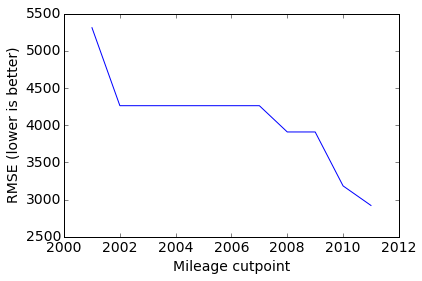

In [27]:
# plot mileage cutpoint (x-axis) versus RMSE (y-axis)
plt.plot(year_1_range, rmse_1)
plt.xlabel('Year cutpoint for cars < 100k miles')
plt.ylabel('RMSE (lower is better)')

**Recap:** Before every split, this process is repeated for every feature, and the feature and cutpoint that produces the lowest MSE is chosen.

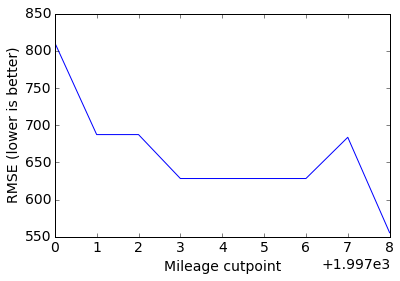

In [28]:
plt.plot(year_2_range, rmse_2)
plt.xlabel('Year cutpoint for cars >= 100k miles')
plt.ylabel('RMSE (lower is better)')

## Building a regression tree in scikit-learn

In [10]:
# encode car as 0 and truck as 1
train['vtype_int'] = train['vtype'].map({'car':0, 'truck':1})

In [12]:
# define X and y
feature_cols = ['year', 'miles', 'doors', 'vtype_int']
X = train[feature_cols]

y = train['price']

In [14]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=1)

dtr(X)

In [ ]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model

## What happens when we grow a tree too deep?

- Left: Regression tree for Salary **grown deeper**
- Right: Comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves

![Salary tree grown deep](images/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with 3 leaves.

## Tuning a regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [46]:
# try different values one-by-one
from sklearn.cross_validation import cross_val_score
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

2928.5714285714284

Or, we could write a loop to try a range of values:

In [62]:
# list of values to try
max_depth_range = range(1, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=100)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

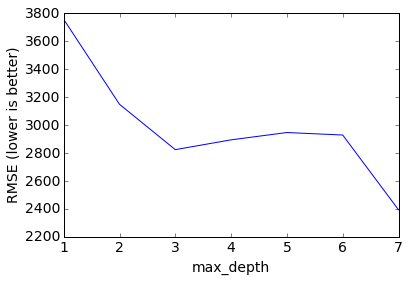

In [63]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [106]:
# max_depth=3 was best, so fit a tree using that parameter
treereg_orig = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg_orig.fit(X,y)
treereg = DecisionTreeRegressor(max_depth=3, random_state=100)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=100, splitter='best')

In [65]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.200239
2,doors,0.001017
3,vtype_int,0.000000


## Creating a tree diagram

In [66]:
# create a Graphviz file
from sklearn.tree import export_graphviz
#export_graphviz(treereg_orig, out_file='tree_vehicles.dot', feature_names=feature_cols)
export_graphviz(treereg, out_file='tree_vehicles_2.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

![Tree for vehicle data](images/tree_vehicles.png)

Reading the internal nodes:

- **samples:** number of observations in that node before splitting
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node
- **rule:** rule used to split that node (go left if true, go right if false)

Reading the leaves:

- **samples:** number of observations in that node
- **value:** mean response value in that node
- **mse:** MSE calculated by comparing the actual response values in that node against "value"

## Making predictions for the testing data

In [103]:
# read the testing data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype_int'] = test['vtype'].map({'car':0, 'truck':1})

In [96]:
test.shape

(3, 7)

In [110]:
def my_pred(df_pred, df):
    class_1 = df[(df.miles < 100000) & (df.year < 2010)].price.mean()
    class_2 = df[(df.miles < 100000) & (df.year >= 2010)].price.mean()
    class_3 = df[(df.miles >= 100000) & (df.year < 2001)].price.mean()
    class_4 = df[(df.miles >= 100000) & (df.year >= 2001)].price.mean()
    
    df_pred['my_pred'] = 0
    df_pred.loc[(df_pred.miles < 100000) & (df_pred.year < 2010), 'my_pred'] = class_1
    df_pred.loc[(df_pred.miles < 100000) & (df_pred.year >= 2010), 'my_pred'] = class_2
    df_pred.loc[(df_pred.miles >= 100000) & (df_pred.year < 2001), 'my_pred'] = class_3
    df_pred.loc[(df_pred.miles >= 100000) & (df_pred.year >= 2001), 'my_pred'] = class_4
    return df_pred

test = my_pred(test, train)

**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [104]:
test[feature_cols]

,year,miles,doors,vtype_int
0,2003,130000,4,1
1,2005,82500,4,0
2,2010,60000,2,0


In [107]:
# use fitted model to make predictions on testing data
test['prediction'] = treereg_orig.predict(test[feature_cols])

In [113]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(test.price, test.prediction))

1190.2380714238084

In [112]:
# calculate RMSE for your own tree!
np.sqrt(metrics.mean_squared_error(test.price, test.my_pred))

2720.9067116190026

In [115]:
np.sqrt(metrics.mean_squared_error([3000, 6000, 12000], [3000, 9250, 13300]))
np.sqrt(metrics.mean_squared_error([3000, 6000, 12000], [2700, 2700, 12083]))

1913.7127091947038

In [111]:
test

,price,year,miles,doors,vtype,vtype_int,prediction,my_pred
0,3000,2003,130000,4,truck,1,4000,2733.333333
1,6000,2005,82500,4,car,0,5000,7833.333333
2,12000,2010,60000,2,car,0,13500,16333.333333


# Part 2: Classification trees

**Example:** Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008:

![Obama-Clinton decision tree](images/obama_clinton_tree.jpg)

**Questions:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- What is the most predictive feature?
- Why does the tree split on high school graduation rate twice in a row?
- What is the class prediction for the following county: 15% African-American, 90% high school graduation rate, located in the South, high poverty, high population density?
- What is the predicted probability for that same county?

## Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

## Splitting criteria for classification trees

Common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region

### Example of classification error rate

Pretend we are predicting whether someone buys an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers), of whom **10 bought iPhones and 15 bought Androids**.
- Since the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 12 Androids, thus the predicted class is Android
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be **5/25 = 20%**

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be **10/25 = 40%**

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure".

Evaluating the split on **gender** using Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index (and thus increases the "node purity") the most.**

### Comparing classification error rate and Gini index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

Note: There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index, but slower to compute, thus it's not as popular as Gini index.

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:

In [ ]:
# read in the data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url)

# encode female as 0 and male as 1
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# fill in the missing values for age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head()

- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** numeric value
- **Embarked:** C or Q or S

In [ ]:
# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [ ]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

In [ ]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

![Tree for Titanic data](images/tree_titanic.png)

Notice the split in the bottom right: the **same class** is predicted in both of its leaves. That split didn't affect the **classification error rate**, though it did increase the **node purity**, which is important because it increases the accuracy of our predicted probabilities.

In [ ]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

# Part 3: Comparing decision trees with other models

**Advantages of decision trees:**

- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Features don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric (will outperform linear models if relationship between features and response is highly non-linear)

![Trees versus linear models](images/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Performance is (generally) not competitive with the best supervised learning methods
- Can easily overfit the training data (tuning is required)
- Small variations in the data can result in a completely different tree (high variance)
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Doesn't tend to work well if the classes are highly unbalanced
- Doesn't tend to work well with very small datasets